# Figure 2/6/7 SIA/Hs90/U10 Time Series
Regional and monthly averaged subplots of the yearly variable timeseries 2020 through 2070. Significance testing is performed using  modified MK test defined by Wang and Swail (2001).

- Wang, Xiaolan L., and Val R. Swail. 2001. “Changes of Extreme Wave Heights in Northern Hemisphere Oceans and Related Atmospheric Circulation Regimes.” Journal of Climate 14 (10): 2204–21. https://doi.org/10.1175/1520-0442(2001)014<2204:COEWHI>2.0.CO;2.

In [5]:
import pandas as pd
import numpy as np
import numpy as np
import pymannkendall as mk
import statsmodels.api as sm
from scipy.optimize import curve_fit
from itertools import product

### Function to read the preprocessed variable data

In [6]:
def read_haz_csv(filepath):
    df = pd.read_csv(filepath)
    column_headers = []
    column_arrays = [] 
    for idx, column in enumerate(df.columns):
        if idx == 0:
            continue
        else:  
            column_data = df[column] 
            column_headers.append(column) 
            column_array = np.array(column_data) 
            column_arrays.append(column_array) 
    data_array = np.column_stack(column_arrays)
    return data_array,column_headers

### Define modified MK test

In [7]:
import pymannkendall as mk

def linear_func(x, a, b):
        return a * x + b

def WS2001_MK(Yt):
    t = np.arange(len(Yt))
    
    #Initial test of c0.  
    c0 = sm.tsa.acf(Yt)
    c0 = c0[1]
    
    #Trim t
    t1 = t[1:]
    
    if c0 < 0.05:
        res = mk.original_test(Yt)
    else:
        Wt = (Yt[1:] - (c0 * Yt[:-1])) / (1 - c0)
        # Define a linear function
        
    
        # Fit the data to the linear function
        popt, _ = curve_fit(linear_func, t1, Wt)
        b0 = popt[0]
    
        Dc = 1
        Db = 1 
        
        while Dc>0.01 or Db>0.01:
            #STEP 2
            Yt1 = Yt[1:] - b0*t1;
            c1 = sm.tsa.acf(Yt1)
            c1 = c1[1]    
            if c1<0.05: 
                c = c0
                b = b0 
                break
            else: 
                Wt = (Yt[1:] - (c1*Yt[:-1]))/(1-c1);
                popt, _ = curve_fit(linear_func, t1, Wt)
                b1 = popt[0]
    
                Dc = np.abs(c1-c0)
                Db = np.abs(b1-b0)

                if Dc<=0.01 and Db<=0.01:
                    c = c1 
                    b = b1
                else:
                    c0 = c1 
                    b0 = b1 
        
        Wt = (Yt[1:] - (c * Yt[:-1])) / (1 - c)
        res = mk.original_test(Wt)
    return res

def detect_trend(x, alpha=0.05):
    res = WS2001_MK(x)
    trend_detected = res.h
    trend_direction = res.trend
    if res.h == True:
        trend_slope = res.slope
    else:
        trend_slope = np.nan
    return trend_detected, trend_direction, trend_slope

---
# Figure 2 SIA Timeseries

### Load the SIA timseries and maximum files to derive average max SIA for the regions

In [14]:
#Maximum SIA data

filename = 'CNRM_SIA_filled_series.csv'
cnrm_max,names = read_haz_csv(filename)
filename = 'ECEARTH_SIA_filled_series.csv'
ecearth_max,names = read_haz_csv(filename)
filename = 'MRI_SIA_filled_series.csv'
mri_max,names = read_haz_csv(filename)
filename = 'MPI_SIA_filled_series.csv'
mpi_max,names = read_haz_csv(filename)

ave_max = np.array([cnrm_max,ecearth_max,mri_max,mpi_max])
ave_max = np.nanmean(ave_max,axis = 0)
BS_max,BB_max,NWP_max = ave_max[0,0],ave_max[0,1],ave_max[0,2]

#Actual SIA data

filename = 'CNRM_SIA_series.csv'
cnrm_sia,names = read_haz_csv(filename)
filename = 'ECEARTH_SIA_series.csv'
ecearth_sia,names = read_haz_csv(filename)
filename = 'MRI_SIA_series.csv'
mri_sia,names = read_haz_csv(filename)
filename = 'MPI_SIA_series.csv'
mpi_sia,names = read_haz_csv(filename)

ave_sia = np.array([cnrm_sia,ecearth_sia,mri_sia,mpi_sia])
ave_sia = np.nanmean(ave_sia,axis = 0)



### Perform the significance tests and plot the time series. 

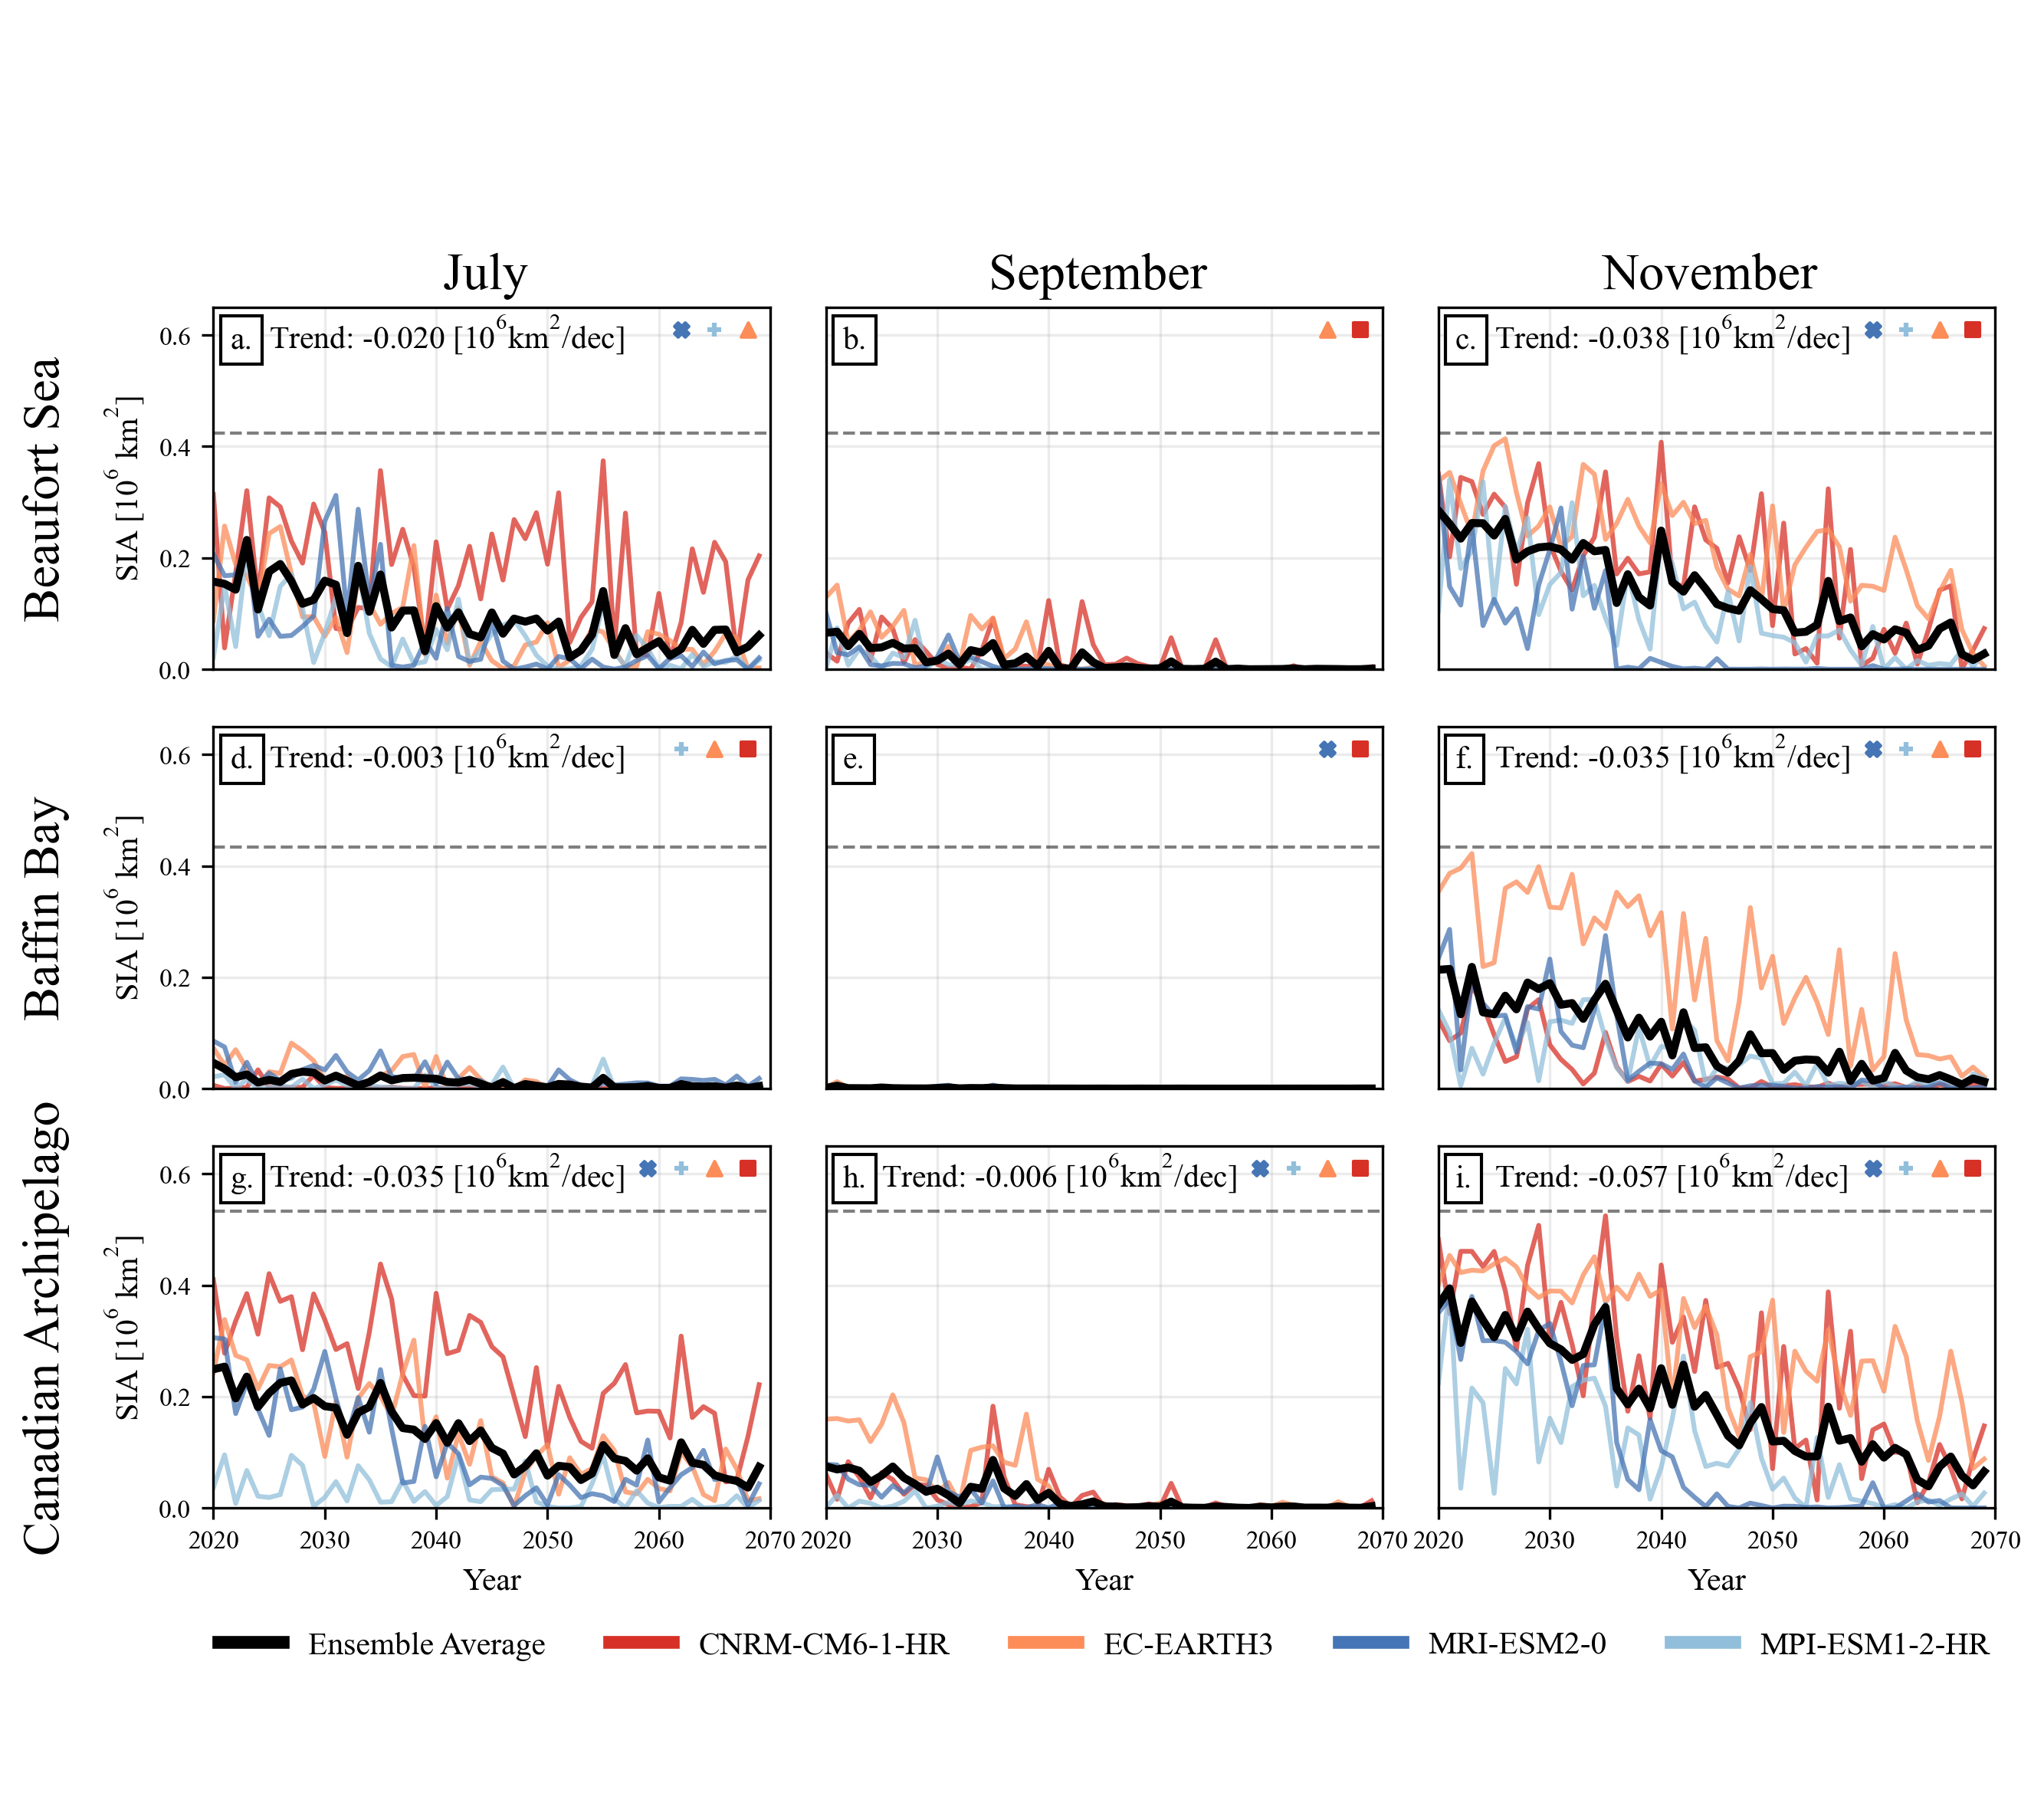

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams["font.family"] = "Times New Roman"


months = ['July ','September ','November ']
regions = ['Beaufort Sea','Baffin Bay', 'Canadian Archipelago'] 
names = [x+str(' ')+y for (x,y) in product(months,regions)]


fig = plt.figure(figsize=(10, 10),dpi =300)
gs = GridSpec(3, 3,hspace= -0.55,wspace= 0.1)
years = np.arange(2020,2070,1)
c_ave,c_cnrm,c_ecearth,c_mpi,c_mri = 'black','#d73027','#fc8d59','#91bfdb', '#4575b4' 
month_names = ['July','','','September','','','November','','']
subplotlabel = ['a.','d.','g.','b.','e.','h.','c.','f.','i.']
for i,region in enumerate(regions):
    for j,month in enumerate(months):
        sigcount = 0
        
        k = (i*3)+j
    
        ax = fig.add_subplot(gs[j,i])
        ax.text(0.03,0.95, subplotlabel[k],fontsize=10, verticalalignment='top',
               bbox=dict(facecolor='white', edgecolor='black', pad=3.0),zorder = 10,transform=ax.transAxes)
        
        ax.plot(years,cnrm_sia[:,k],label = '_nolegend_',linewidth = 1.5,alpha = 0.75,color = c_cnrm)
        ax.plot(years,ecearth_sia[:,k],label = '_nolegend_',linewidth = 1.5,alpha = 0.75,color = c_ecearth)
        ax.plot(years,mpi_sia[:,k],label = '_nolegend_',linewidth = 1.5,alpha = 0.75, color = c_mpi)
        ax.plot(years,mri_sia[:,k],label = '_nolegend_',linewidth = 1.5,alpha = 0.75,color = c_mri)
        ax.plot(years,ave_sia[:,k],color = 'black',label = '_nolegend_',linewidth = 2.5)
        

        changes_detected_cnrm, change_direction,cnrm_slope = detect_trend(cnrm_sia[:,k])
        changes_detected_ecearth, change_direction,ecearth_slope = detect_trend(ecearth_sia[:,k])
        changes_detected_mpi, change_direction, mpi_slope = detect_trend(mpi_sia[:,k])
        changes_detected_mri, change_direction,mri_slope = detect_trend(mri_sia[:,k])
        
        scatter_x = 2068
        sigcount = 0
        if changes_detected_cnrm:
            ax.scatter(scatter_x, 0.61, marker='s',s =20, color=c_cnrm,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        if changes_detected_ecearth:
            ax.scatter(scatter_x, 0.61, marker='^',s =20, color=c_ecearth,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        if changes_detected_mpi:
            ax.scatter(scatter_x, 0.61, marker='+',s =20, color=c_mpi,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        if changes_detected_mri:
            ax.scatter(scatter_x, 0.61, marker='X',s =20, color=c_mri,zorder = 100)
            scatter_x -= 3
            sigcount += 1

        if sigcount > 2.5:
            trend = np.nanmean([cnrm_slope,ecearth_slope,mri_slope,mpi_slope])*10
            ax.text(0.1,0.985, f'Trend: {trend:.3f}'+' [10$\mathregular{^{6}}$km$\mathregular{^{2}}$/dec]' ,fontsize=10,
                    verticalalignment='top',horizontalalignment='left',zorder = 10,transform=ax.transAxes)

        ax.set_xlim(2020, 2070)
        ax.set_ylim(0, 0.65)
        
        ax.set_yticks(np.arange(0, 0.7, 0.2))
        ax.set_aspect(50)
        ax.grid(alpha = 0.25)

        #Top row of plots
        if k in [0,3,6]:
            ax.axhline(y=BS_max, color='black', linestyle='--',alpha = 0.5,linewidth = 1)
            ax.set_title(months[i],fontsize = 16)

        if k in [1,4,7]:
            ax.axhline(y=BB_max, color='black', linestyle='--',alpha = 0.5,linewidth = 1)

        #General plot params
        ax.tick_params(
            axis='x',         
            which='both',      
            bottom=False,     
            top=False,        
            labelbottom=False)
        
        ax.tick_params(
                axis='y',         
                which='both',      
                left=False,    
                right=False,        
                labelleft=False)
        
        
        
        #Bottom row of plots
        if k in [2,5,8]:
            ax.axhline(y=NWP_max, color='black', linestyle='--',alpha =0.5, linewidth = 1)
            ax.set_xlabel("Year")
            ax.set_xticks(np.arange(2020, 2071, 10))
            ax.tick_params(
                axis='x',          
                which='both',      
                bottom=True,      
                top=False,         
                labelbottom=True,
                labelsize =8)
    
        # Left column of plots    
        if k in [0,1,2]:
            label_ax = plt.Subplot(fig,gs[j,i])
            label_ax.text(-0.3, 0.5,regions[j], va='center', ha='center', rotation=90,fontsize = 16)
            fig.add_subplot(label_ax)
            label_ax.axis('off')
            ax.set_ylabel('SIA [10$\mathregular{^{6}}$ km$\mathregular{^{2}}$]')
            ax.tick_params(
                axis='y',          
                which='both',      
                left=True,     
                right=False,       
                labelleft=True,
                labelsize =8)

        #Legend
        if k == 5:
            color = c_ave
            label = 'Ensemble Average'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_cnrm
            label = 'CNRM-CM6-1-HR'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_ecearth
            label = 'EC-EARTH3'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_mri
            label = 'MRI-ESM2-0'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_mpi
            label = 'MPI-ESM1-2-HR'
            plt.plot([], c=color, label=label,linewidth = 4)
            ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),ncol = 5,frameon=False,fontsize=10)

            
plt.savefig('FIGURE2.tif', bbox_inches='tight', dpi=200) 
plt.show()


---
# Figure 6 Hs90 Timeseries

### Read the preprocessed Hs90 timseries

In [17]:
filename = 'CNRM_Hs90_series.csv'
cnrm_hs90,names = read_haz_csv(filename)
filename = 'ECEARTH_Hs90_series.csv'
ecearth_hs90,names = read_haz_csv(filename)
filename = 'MRI_Hs90_series.csv'
mri_hs90,names = read_haz_csv(filename)
filename = 'MPI_Hs90_series.csv'
mpi_hs90,names = read_haz_csv(filename)

ave_hs90 = np.array([cnrm_hs90,ecearth_hs90,mri_hs90,mpi_hs90])
ave_hs90 = np.nanmean(ave_hs90,axis = 0)


### Perform the significance tests and plot the time series. 

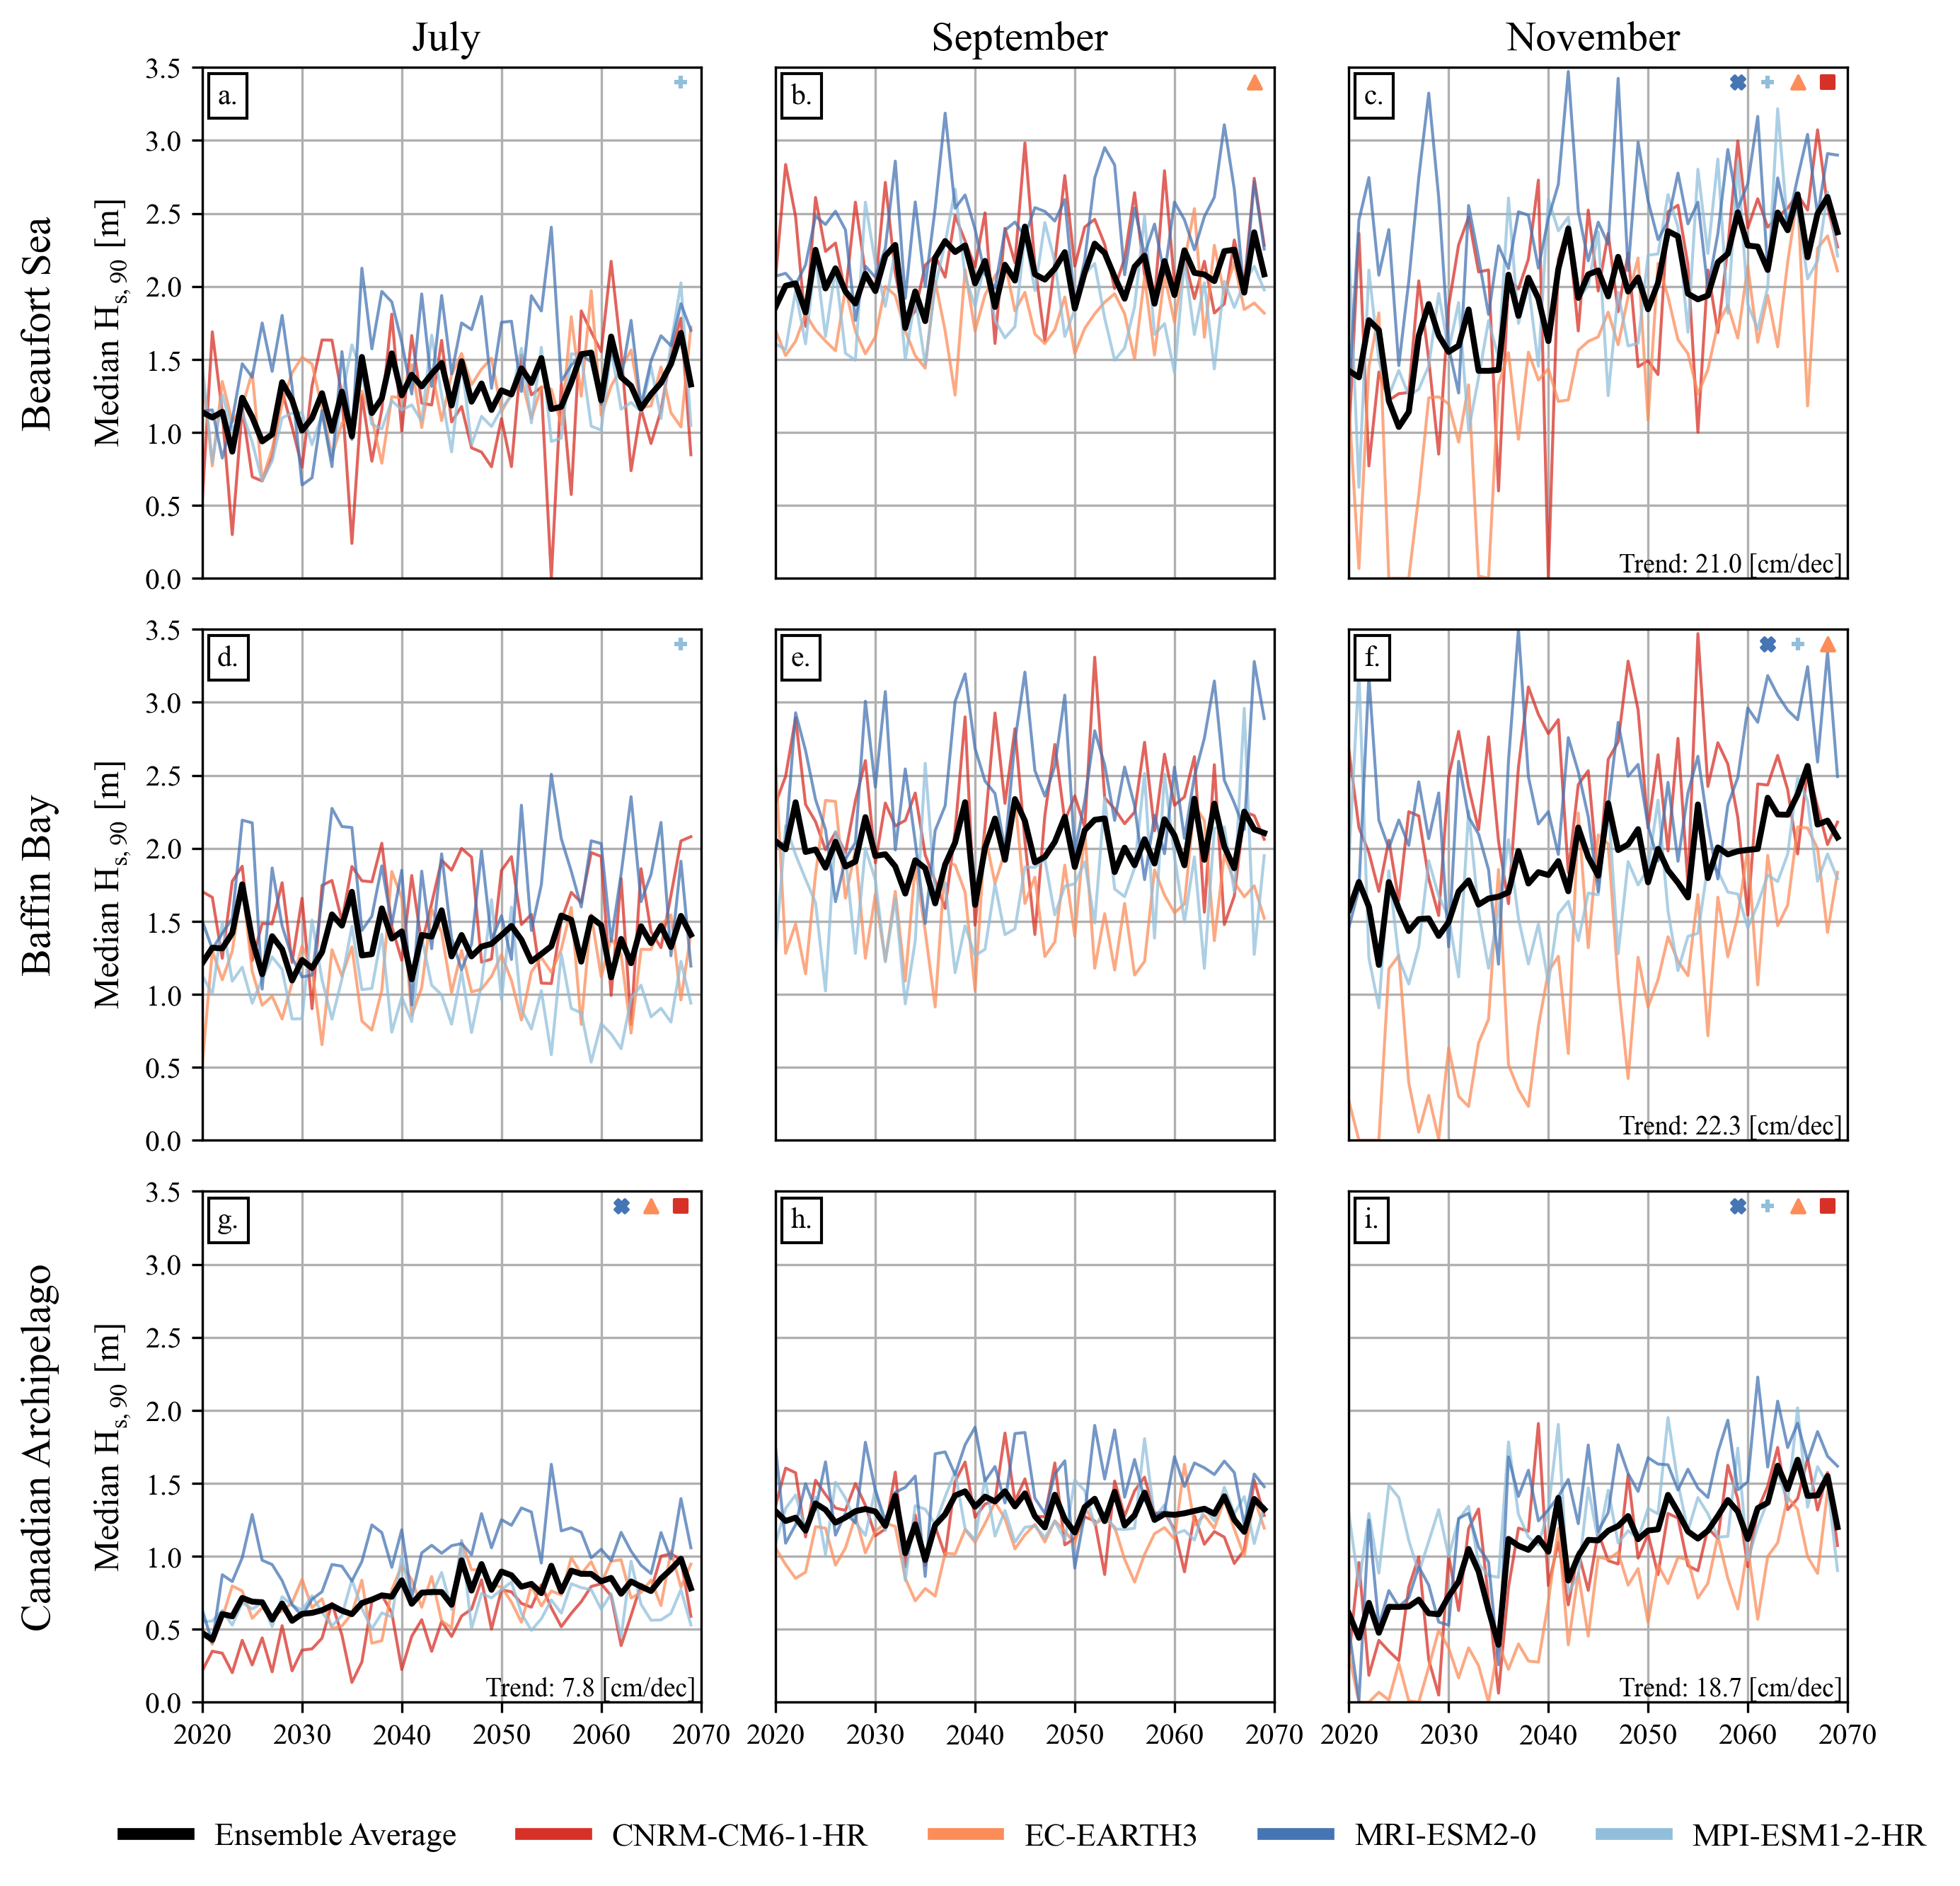

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams["font.family"] = "Times New Roman"

months = ['July ','September ','November ']
regions = ['Beaufort Sea','Baffin Bay', 'Canadian Archipelago'] 
names = [x+str(' ')+y for (x,y) in product(months,regions)]

fig = plt.figure(figsize=(10, 10),dpi =300)
gs = GridSpec(3, 3,hspace= 0.1,wspace= 0.15)
years = np.arange(2020,2070,1)
c_ave,c_cnrm,c_ecearth,c_mpi,c_mri = 'black','#d73027','#fc8d59','#91bfdb', '#4575b4' 
month_names = ['July','','','September','','','November','','']
subplotlabel = ['a.','d.','g.','b.','e.','h.','c.','f.','i.']

for i,region in enumerate(regions):
    for j,month in enumerate(months):
        k = (i*3)+j
        ax = fig.add_subplot(gs[j,i])
        ax.text(0.03,0.97, subplotlabel[k],fontsize=10, verticalalignment='top',
               bbox=dict(facecolor='white', edgecolor='black', pad=3.0),zorder = 10,transform=ax.transAxes)
        ax.plot(years,cnrm_hs90[:,k],label = '_nolegend_',linewidth = 1,alpha = 0.75,color = c_cnrm)
        ax.plot(years,ecearth_hs90[:,k],label = '_nolegend_',linewidth = 1,alpha = 0.75,color = c_ecearth)
        ax.plot(years,mpi_hs90[:,k],label = '_nolegend_',linewidth = 1,alpha = 0.75, color = c_mpi)
        ax.plot(years,mri_hs90[:,k],label = '_nolegend_',linewidth = 1,alpha = 0.75,color = c_mri)
        ax.plot(years,ave_hs90[:,k],color = 'black',label = '_nolegend_',linewidth = 2)
        
        changes_detected_cnrm, change_direction,cnrm_slope = detect_trend(cnrm_hs90[:,k])
        changes_detected_ecearth, change_direction,ecearth_slope = detect_trend(ecearth_hs90[:,k])
        changes_detected_mpi, change_direction,mpi_slope = detect_trend(mpi_hs90[:,k])
        changes_detected_mri, change_direction,mri_slope = detect_trend(mri_hs90[:,k])
        
        scatter_x = 2068
        sigcount = 0

        if changes_detected_cnrm:
            ax.scatter(scatter_x, 3.4, marker='s',s =20, color=c_cnrm,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        if changes_detected_ecearth:
            ax.scatter(scatter_x, 3.4, marker='^',s =20, color=c_ecearth,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        if changes_detected_mpi:
            ax.scatter(scatter_x, 3.4, marker='+',s =20, color=c_mpi,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        if changes_detected_mri:
            ax.scatter(scatter_x, 3.4, marker='X',s =20, color=c_mri,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        
        
        if sigcount > 2.5:
            trend = np.nanmean([cnrm_slope,ecearth_slope,mri_slope,mpi_slope])*10*100
            ax.text(0.99,0.05, f'Trend: {trend:.1f} [cm/dec]' ,fontsize=9, verticalalignment='top',
                     horizontalalignment='right',zorder = 10,transform=ax.transAxes)

        ax.set_xlim(2020, 2070)
        ax.set_ylim(0, 3.5)
        ax.set_yticks(np.arange(0, 3.6, 0.5))
        ax.grid()

        if k in [0,3,6]:
            ax.set_title(months[i],fontsize = 14)

        ax.tick_params(
            axis='x',         
            which='both',     
            bottom=False,      
            top=False,         
            labelbottom=False)
        
        ax.tick_params(
                axis='y',         
                which='both',      
                left=False,      
                right=False,         
                labelleft=False)
        
        if k in [2,5,8]:
            ax.set_xticks(np.arange(2020, 2071, 10))
            ax.tick_params(
                axis='x',          
                which='both',      
                bottom=True,      
                top=False,         
                labelbottom=True,
                labelsize =10)
    
        if k in [0,1,2]:
            label_ax = plt.Subplot(fig,gs[j,i])
            label_ax.text(-0.325, 0.5,regions[j], va='center', ha='center', rotation=90,fontsize = 14)
            fig.add_subplot(label_ax)
            label_ax.axis('off')
            ax.set_ylabel('Median H$\mathregular{_{s,90}}$ [m]',fontsize = 12)
            ax.tick_params(
                axis='y',          
                which='both',     
                left=True,      
                right=False,        
                labelleft=True,
                labelsize =10)

        if k == 5:
            color = c_ave
            label = 'Ensemble Average'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_cnrm
            label = 'CNRM-CM6-1-HR'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_ecearth
            label = 'EC-EARTH3'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_mri
            label = 'MRI-ESM2-0'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_mpi
            label = 'MPI-ESM1-2-HR'
            plt.plot([], c=color, label=label,linewidth = 4)
            ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35),ncol = 5,frameon=False,fontsize=11)

            
plt.savefig('FIGURE6.tif', bbox_inches='tight', dpi=200)  # Adjust dpi as needed 
plt.show()


---
# Figure 7 U10 Timeseries
This analysis was implemented at the request of the reviewers.


### Read the preprocessed u10 timseries

In [22]:
filename = 'CNRM_u10_90_series.csv'
cnrm_u10,names = read_haz_csv(filename)
filename = 'ECEARTH_u10_90_series.csv'
ecearth_u10,names = read_haz_csv(filename)
filename = 'MRI_u10_90_series.csv'
mri_u10,names = read_haz_csv(filename)
filename = 'MPI_u10_90_series.csv'
mpi_u10,names = read_haz_csv(filename)

ave_u10 = np.array([cnrm_u10,ecearth_u10,mri_u10,mpi_u10])
ave_u10 = np.nanmean(ave_u10,axis = 0)


### Perform the significance tests and plot the time series. 

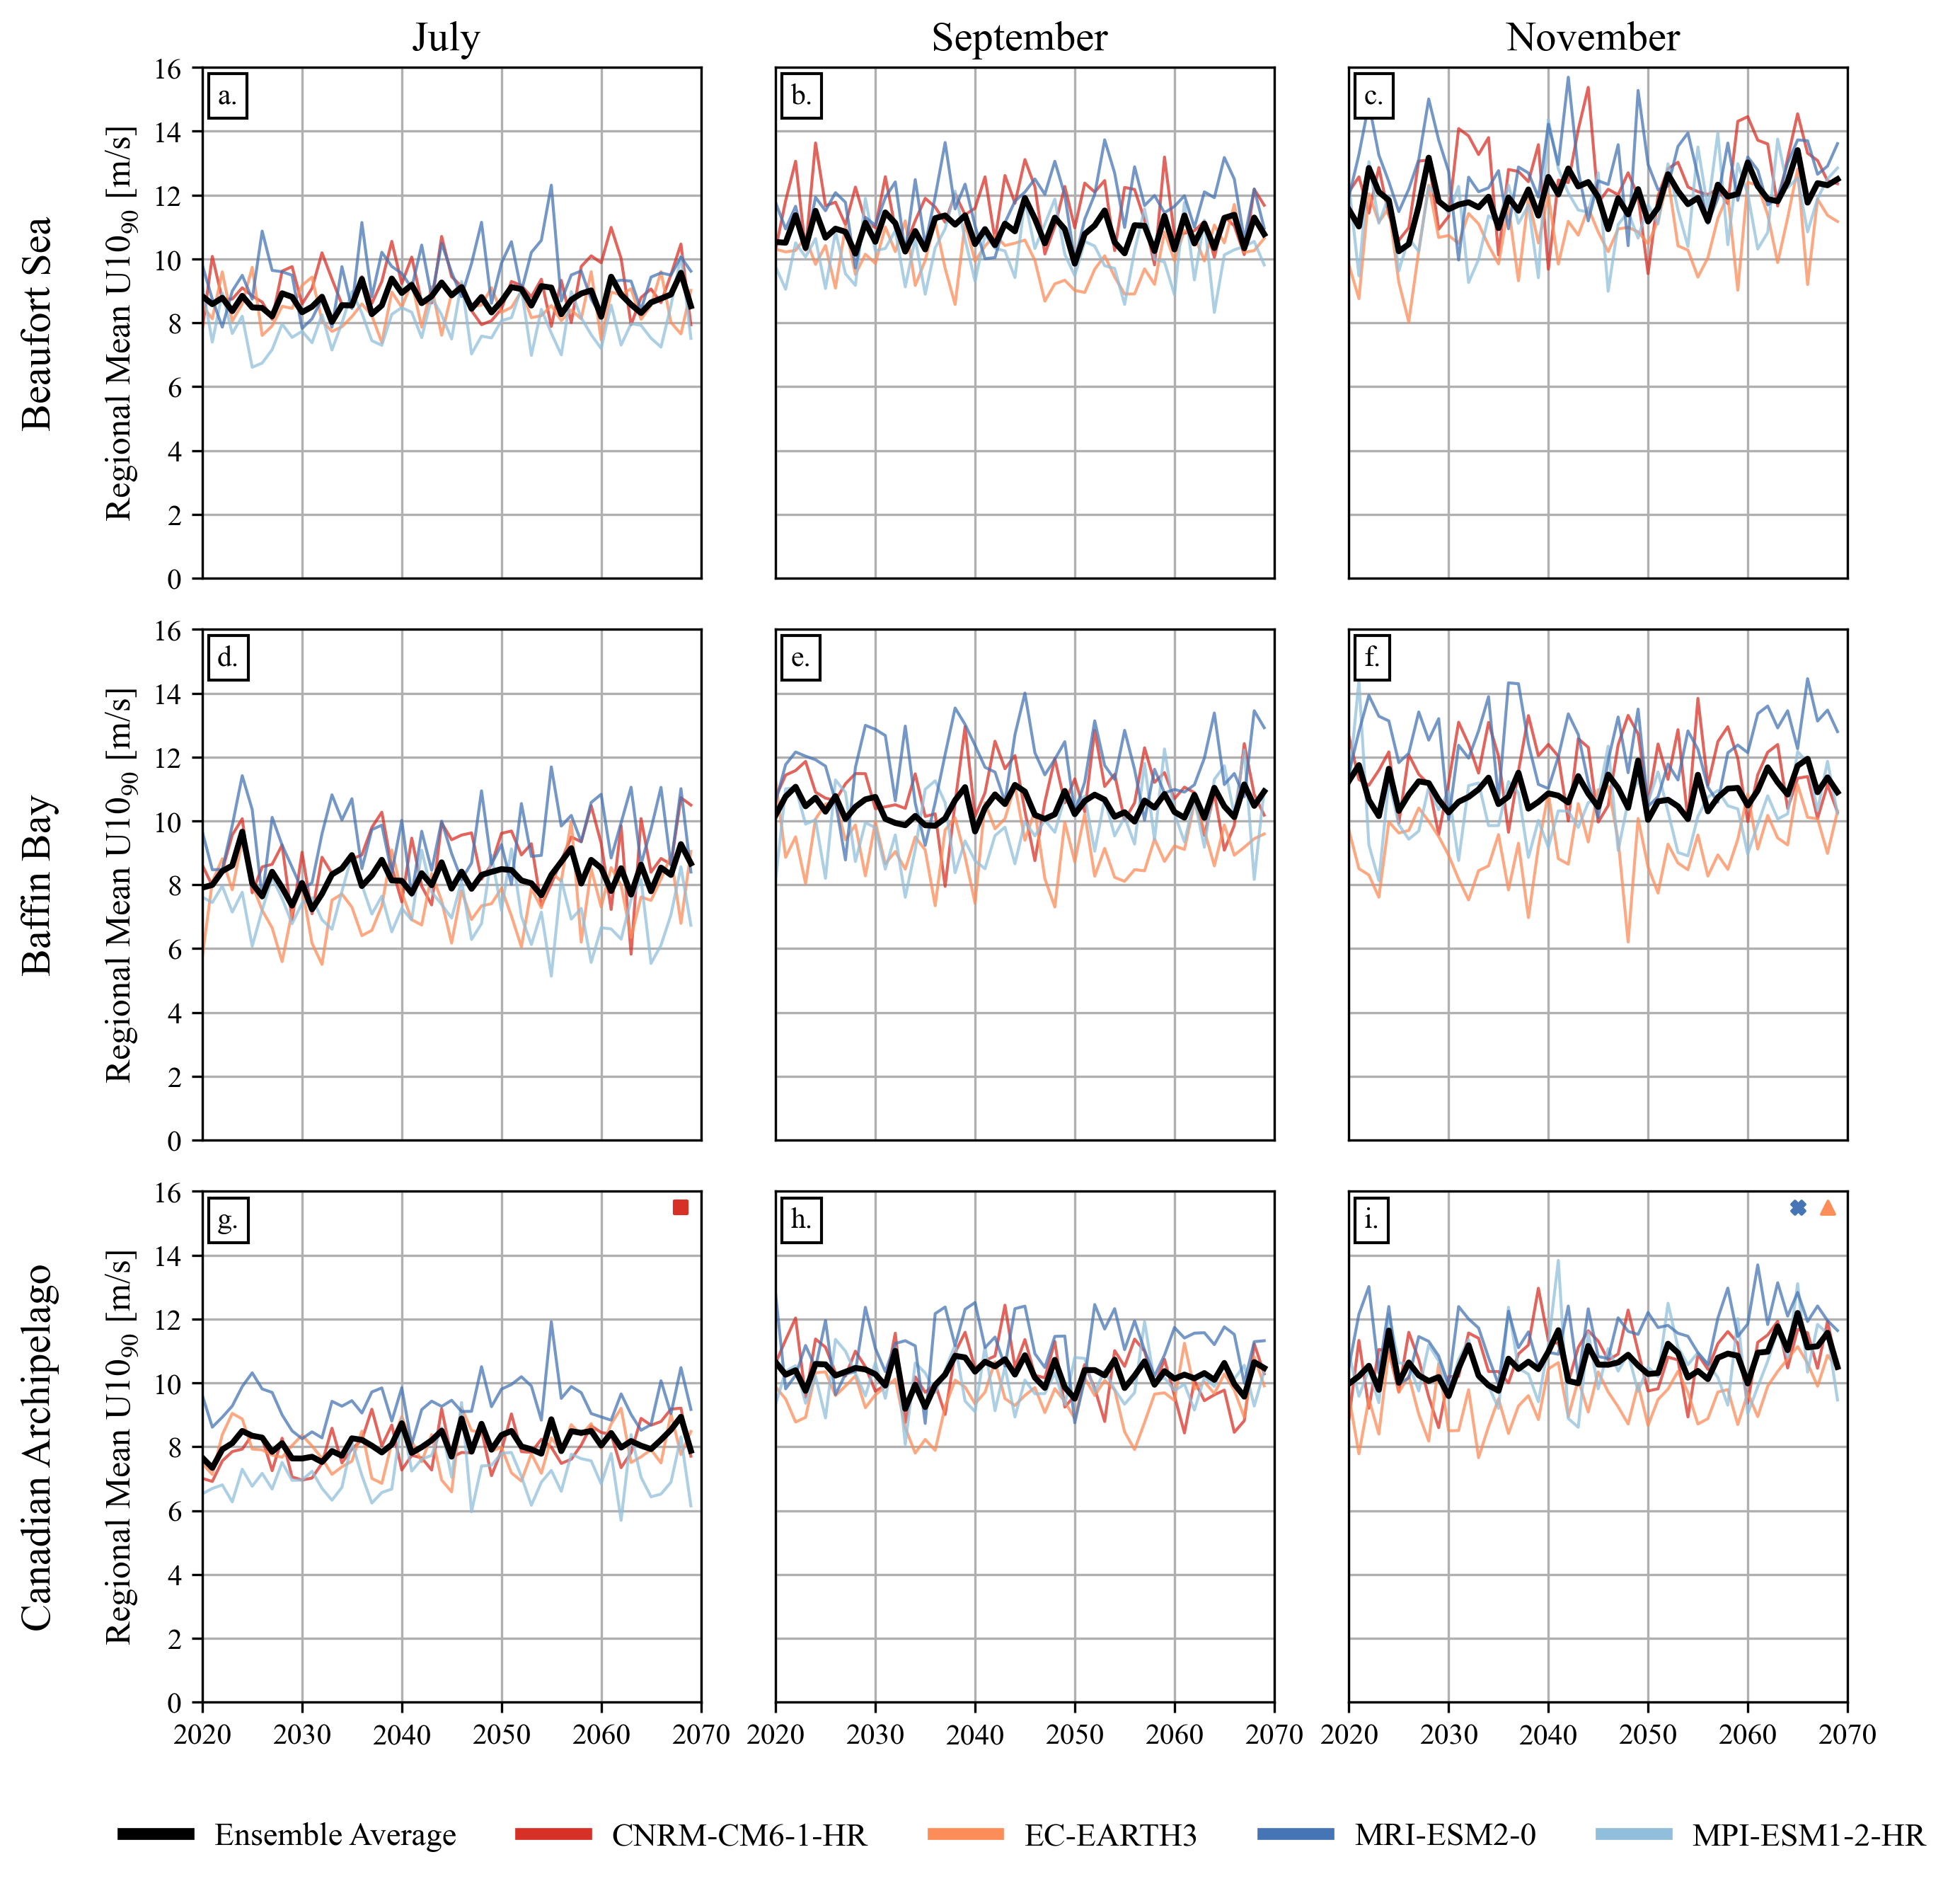

In [27]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams["font.family"] = "Times New Roman"

months = ['July ','September ','November ']
regions = ['Beaufort Sea','Baffin Bay', 'Canadian Archipelago'] 
names = [x+str(' ')+y for (x,y) in product(months,regions)]

fig = plt.figure(figsize=(10, 10),dpi =300)
gs = GridSpec(3, 3,hspace= 0.1,wspace= 0.15)
years = np.arange(2020,2070,1)
c_ave,c_cnrm,c_ecearth,c_mpi,c_mri = 'black','#d73027','#fc8d59','#91bfdb', '#4575b4' 
month_names = ['July','','','September','','','November','','']
subplotlabel = ['a.','d.','g.','b.','e.','h.','c.','f.','i.']
for i,region in enumerate(regions):
    for j,month in enumerate(months):
        k = (i*3)+j
    

        ax = fig.add_subplot(gs[j,i])
        ax.text(0.03,0.97, subplotlabel[k],fontsize=10, verticalalignment='top',
               bbox=dict(facecolor='white', edgecolor='black', pad=3.0),zorder = 10,transform=ax.transAxes)
        ax.plot(years,cnrm_u10[:,k],label = '_nolegend_',linewidth = 1,alpha = 0.75,color = c_cnrm)
        ax.plot(years,ecearth_u10[:,k],label = '_nolegend_',linewidth = 1,alpha = 0.75,color = c_ecearth)
        ax.plot(years,mpi_u10[:,k],label = '_nolegend_',linewidth = 1,alpha = 0.75, color = c_mpi)
        ax.plot(years,mri_u10[:,k],label = '_nolegend_',linewidth = 1,alpha = 0.75,color = c_mri)
        ax.plot(years,ave_u10[:,k],color = 'black',label = '_nolegend_',linewidth = 2)

        changes_detected_cnrm, change_direction,cnrm_slope = detect_trend(cnrm_u10[:,k])
        changes_detected_ecearth, change_direction,ecearth_slope = detect_trend(ecearth_u10[:,k])
        changes_detected_mpi, change_direction,mpi_slope = detect_trend(mpi_u10[:,k])
        changes_detected_mri, change_direction, mri_slope = detect_trend(mri_u10[:,k])
        
        scatter_x = 2068
        sigcount = 0

        if changes_detected_cnrm:
            ax.scatter(scatter_x, 15.5, marker='s',s =20, color=c_cnrm,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        if changes_detected_ecearth:
            ax.scatter(scatter_x, 15.5, marker='^',s =20, color=c_ecearth,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        if changes_detected_mpi:
            ax.scatter(scatter_x, 15.5, marker='+',s =20, color=c_mpi,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        if changes_detected_mri:
            ax.scatter(scatter_x, 15.5, marker='X',s =20, color=c_mri,zorder = 100)
            scatter_x -= 3
            sigcount += 1
        
        
        if sigcount > 2.5:
            trend = np.nanmean([cnrm_slope,ecearth_slope,mri_slope,mpi_slope])*10*100
            ax.text(0.99,0.05, f'Trend: {trend:.1f} [cm/dec]' ,fontsize=9, verticalalignment='top',
                     horizontalalignment='right',zorder = 10,transform=ax.transAxes)
        ax.set_xlim(2020, 2070)
        ax.set_ylim(0, 16)
        
        ax.set_yticks(np.arange(0, 18, 2))
        
        ax.grid()
        
        #Top row of plots
        if k in [0,3,6]:
            ax.set_title(months[i],fontsize = 14)
        
        ax.tick_params(
            axis='x',          
            which='both',      
            bottom=False,     
            top=False,         
            labelbottom=False)
        
        ax.tick_params(
                axis='y',         
                which='both',      
                left=False,     
                right=False,         
                labelleft=False)
        
        if k in [2,5,8]:
            ax.set_xticks(np.arange(2020, 2071, 10))
            ax.tick_params(
                axis='x',         
                which='both',     
                bottom=True,      
                top=False,         
                labelbottom=True,
                labelsize =10)
    
        if k in [0,1,2]:
            label_ax = plt.Subplot(fig,gs[j,i])
            label_ax.text(-0.325, 0.5,regions[j], va='center', ha='center', rotation=90,fontsize = 14)
            fig.add_subplot(label_ax)
            label_ax.axis('off')
            ax.set_ylabel('Regional Mean U10$\mathregular{_{90}}$ [m/s]',fontsize = 12)
            ax.tick_params(
                axis='y',          
                which='both',      
                left=True,     
                right=False,       
                labelleft=True,
                labelsize =10)

        if k == 5:
            color = c_ave
            label = 'Ensemble Average'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_cnrm
            label = 'CNRM-CM6-1-HR'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_ecearth
            label = 'EC-EARTH3'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_mri
            label = 'MRI-ESM2-0'
            plt.plot([], c=color, label=label,linewidth = 4)
            
            color = c_mpi
            label = 'MPI-ESM1-2-HR'
            plt.plot([], c=color, label=label,linewidth = 4)
            ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35),ncol = 5,frameon=False,fontsize=11)

            
plt.savefig('FIGURE7.tif', bbox_inches='tight', dpi=200)
plt.show()
